Cellchat analysis goes here.

In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(CellChat)
library(ComplexHeatmap)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.11.1-CAPI-1.17.1
and GEOS at installation 3.10.3-CAPI-1.16.1differ”
Attaching SeuratObject

Attaching sp

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘pack

# Cell-cell communication analysis

We generated a Seurat object with cells from the four organoid+fibroblast cocultures from the first run:

* 03_WT-Fib: cocultWTFib
* 07_A-Fib: cocultAFib
* 11_AK-Fib: cocultAKFib
* 15_AKP-Fib: cocultAKPFib

It can be found in the Zenodo repository or, alternatively, a downsampled version is present locally within the data directory. This downsampled version was generated using the code below:

    cocultsINT <- readRDS("../OnRequest/cocultsINT.rds")
    cocultsINT = SetIdent(cocultsINT, value="orig.ident")
    downsampled_cocultsINT <- subset(downsampled_cocultsINT, downsample = 80)
    saveRDS(downsampled_cocultsINT, "data/downsampled_cocultsINT.rds")


In [2]:
#Load the downsampled local version

    downsampled_cocultsINT <- readRDS("data/downsampled_cocultsINT.rds")
    downsampled_cocultsINT@meta.data$orig.ident <- factor(
                                    downsampled_cocultsINT@meta.data$orig.ident,
                                    levels = c('cocultWTFib','cocultAFib',
                                        'cocultAKFib','cocultAKPFib')
                                )

The individual Seurat objects used in this analysis can be found within the RDS lists in Zenodo with the following names:

* crctmeWT.rds
* crctmeA.rds
* crctmeAK.rds
* crctmeAKP.rds

These were QCed as shown in the exploration notebook and we replaced cluster annotations for the epithelial cells within for the curatedCLUST metadata shown throughout the manuscript.

From them, we created CellChat objects and performed the standard CellChat analysis workflow to generate the Incoming/Outgoing Communication probability plots.

    CellChatObject <- createCellChat(object = SeuratObject,
                           meta = NULL,
                           group.by ="finalPOPS", #Cluster annotations
                           assay = "RNA",
                           do.sparse = TRUE)

    computeCommunProbPathway(CellChatObject, thresh = 0.05)

Resulting object list:

* 03_WT-Fib: cc_fibWT
* 07_A-Fib: cc_fibA
* 11_AK-Fib: cc_fibAK
* 15_AKP-Fib: cc_fibAKP

In [3]:
#Load CellChat objects

    cc_fibWT <- readRDS("data/CC_fibWT.rds")
    cc_fibA <- readRDS("data/CC_fibA.rds")
    cc_fibAK <- readRDS("data/CC_fibAK.rds")
    cc_fibAKP <- readRDS("data/CC_fibAKP.rds")

Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Signaling role analysis on the aggregated cell-ce

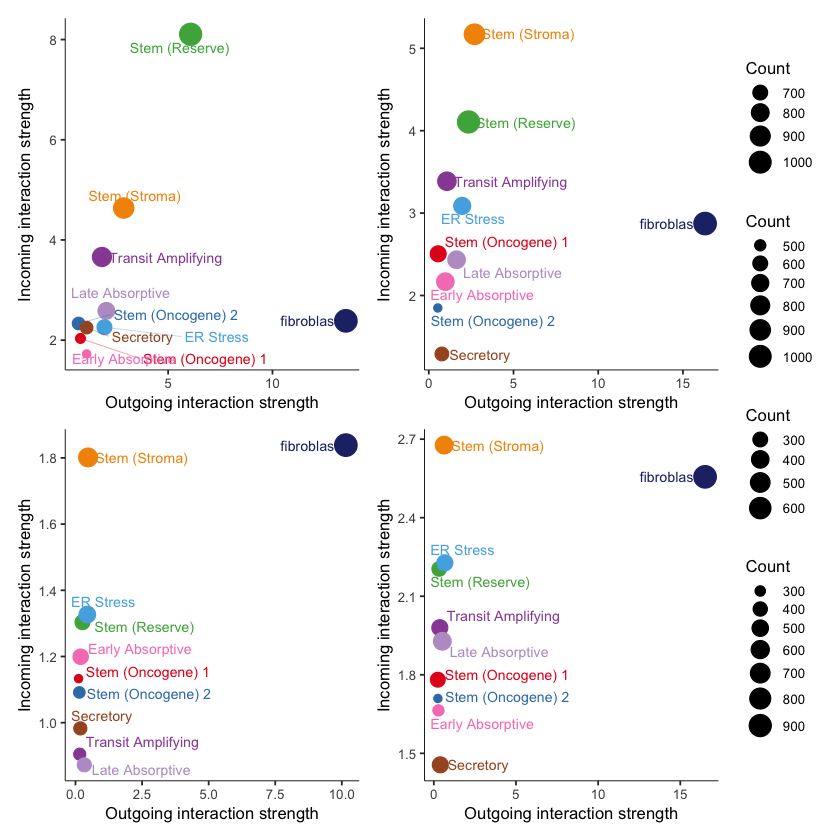

In [4]:
#Create baseline for the plots in Fig5A

    netAnalysis_signalingRole_scatter(cc_fibWT) +
    netAnalysis_signalingRole_scatter(cc_fibA) + 
    netAnalysis_signalingRole_scatter(cc_fibAK) +
    netAnalysis_signalingRole_scatter(cc_fibAKP) +
    plot_layout(ncol = 2, nrow = 2, guides = "collect")

In [5]:
#Determine the weight of the arrow annotations

    #Define the epithelial cluster (Note the changed cluster names here!)
    epiPOPS <- c(
        "Stem (Oncogene) 1",# ~ "proCSC"
        "Stem (Oncogene) 2",# ~ "CSC"
        "Stem (Reserve)",# ~ "TA 2"                        
        "Transit Amplifying",# ~ "TA 1"
        "Stem (Stroma)",# ~ "revCSC"
        "Early Absorptive",# ~ "Early Enterocyte"
        "Late Absorptive",# ~ "Late Enterocyte"
        "Secretory",# ~ "Goblet / DCS"
        "ER Stress")#
    dPanelA_edges <- bind_rows(
        subsetCommunication(cc_fibWT, sources.use = c("fibroblast"), 
                            targets.use = epiPOPS) %>% group_by(target) %>% summarise(sum(prob)),
        subsetCommunication(cc_fibA, sources.use = c("fibroblast"), 
                            targets.use = epiPOPS) %>% group_by(target) %>% summarise(sum(prob)),
        subsetCommunication(cc_fibAK, sources.use = c("fibroblast"), 
                            targets.use = epiPOPS) %>% group_by(target) %>% summarise(sum(prob)),
        subsetCommunication(cc_fibAKP, sources.use = c("fibroblast"), 
                            targets.use = epiPOPS) %>% group_by(target) %>% summarise(sum(prob)),
        .id = "Genotype"
                                ) %>%
    mutate(CustomScale = scales::rescale(`sum(prob)`, to=c(0.1,1)))
    dPanelA_edges

Genotype,target,sum(prob),CustomScale
<chr>,<fct>,<dbl>,<dbl>
1,Stem (Oncogene) 1,0.8038564,0.2180066
1,Stem (Oncogene) 2,1.0418805,0.2907056
1,Stem (Reserve),3.3641828,1.0000000
1,Transit Amplifying,1.7285179,0.5004234
1,Stem (Stroma),2.1595490,0.6320720
1,Early Absorptive,0.6907363,0.1834566
1,Late Absorptive,0.8904784,0.2444633
1,Secretory,0.7397301,0.1984207
1,ER Stress,0.5786190,0.1492130


To build the heatmaps shown in Fig2B we leveraged CellChat's ability to merge 
individual objects to analyse communication across multiple conditions. 

In [6]:
#Load merged object

    cc_merged <- readRDS("data/CC_merged.rds")
    cc_merged

An object of class CellChat created from a merged object with multiple datasets 
 573 signaling genes.
 14546 cells.

Based on the Cell-Cell communications found on that object we then built the 
interaction- and pathway-level heatmaps shown.

We used the subsetCommunication() function to find cell-cell communication both at the interaction and pathway levels by changing the `slot.name` parameter

    dCellComm_prob <- bind_rows(
                    subsetCommunication(cc_merged,
                      sources.use = c("fibroblast"), targets.use = epiPOPS,
                      slot.name = "netP")[[1]],#WT
                    subsetCommunication(cc_merged, 
                      sources.use = c("fibroblast"), targets.use = epiPOPS, 
                      slot.name = "netP")[[2]], #a
                    subsetCommunication(cc_merged, 
                      sources.use = c("fibroblast"), targets.use = epiPOPS, 
                      slot.name = "netP")[[3]], #ak
                    subsetCommunication(cc_merged, 
                      sources.use = c("fibroblast"), targets.use = epiPOPS, 
                      slot.name = "netP")[[4]], #akp
                    .id = "Genotype"
                            ) %>% group_by(target, pathway_name)
    dCellComm_prob_interaction <- bind_rows(
                    subsetCommunication(cc_merged,
                      sources.use = c("fibroblast"), targets.use = epiPOPS,
                      slot.name = "net")[[1]],#WT
                    subsetCommunication(cc_merged, 
                      sources.use = c("fibroblast"), targets.use = epiPOPS, 
                      slot.name = "net")[[2]], #a
                    subsetCommunication(cc_merged, 
                      sources.use = c("fibroblast"), targets.use = epiPOPS, 
                      slot.name = "net")[[3]], #ak
                    subsetCommunication(cc_merged, 
                      sources.use = c("fibroblast"), targets.use = epiPOPS, 
                      slot.name = "net")[[4]], #akp
                    .id = "Genotype"
                            ) %>% group_by(target, interaction_name)

Processed versions of these dataframes (with added metrics regarding comparisons of the different genotypes VS the WT) can be found locally and loaded as follows:

In [7]:
dCC_pathway <- read_csv("data/CC_resultsPathway.csv")
dCC_pathway$Genotype <- factor(
    dCC_pathway$Genotype, 
    levels = c("WT","A","AK","AKP"))
dCC_pathway$Columns <- factor(dCC_pathway$Columns,
    levels = c(
                
                "WT_Stem (Oncogene) 1", 
                "WT_Stem (Oncogene) 2",
                "WT_Stem (Stroma)",
                "WT_Transit Amplifying",
                "WT_Stem (Reserve)",
                "WT_ER Stress",
                "WT_Secretory",
                "WT_Early Absorptive",
                "WT_Late Absorptive",
                "WT_fibroblast",
                
                
                "A_Stem (Oncogene) 1", 
                "A_Stem (Oncogene) 2",
                "A_Stem (Stroma)",
                "A_Transit Amplifying",
                "A_Stem (Reserve)",
                "A_ER Stress",
                "A_Secretory",
                "A_Early Absorptive",
                "A_Late Absorptive",
                "A_fibroblast",
                
                
                "AK_Stem (Oncogene) 1", 
                "AK_Stem (Oncogene) 2",
                "AK_Stem (Stroma)",
                "AK_Transit Amplifying",
                "AK_Stem (Reserve)",
                "AK_ER Stress",
                "AK_Secretory",
                "AK_Early Absorptive",
                "AK_Late Absorptive",
                "AK_fibroblast",
                
                
                "AKP_Stem (Oncogene) 1", 
                "AKP_Stem (Oncogene) 2",
                "AKP_Stem (Stroma)",
                "AKP_Transit Amplifying",
                "AKP_Stem (Reserve)",
                "AKP_ER Stress",
                "AKP_Secretory",
                "AKP_Early Absorptive",
                "AKP_Late Absorptive",
                "AKP_fibroblast"
                
            )
)
dCC_interaction <- read_csv("data/CC_resultsInteraction.csv")
dCC_interaction$Genotype <- factor(
    dCC_interaction$Genotype, 
    levels = c("WT","A","AK","AKP"))
dCC_interaction$Columns <- factor(
    dCC_interaction$Columns,
    levels = c(
                
                    
                "WT_Stem (Oncogene) 2",
                "WT_Stem (Oncogene) 1",
                "WT_Stem (Stroma)",
                "WT_Transit Amplifying",
                "WT_Stem (Reserve)",
                "WT_ER Stress",
                "WT_Secretory",
                "WT_Early Absorptive",
                "WT_Late Absorptive",
                "WT_fibroblast",
                
                "A_Stem (Oncogene) 2",
                "A_Stem (Oncogene) 1", 
                "A_Stem (Stroma)",
                "A_Transit Amplifying",
                "A_Stem (Reserve)",
                "A_ER Stress",
                "A_Secretory",
                "A_Early Absorptive",
                "A_Late Absorptive",
                "A_fibroblast",
                
                "AK_Stem (Oncogene) 2",
                "AK_Stem (Oncogene) 1", 
                "AK_Stem (Stroma)",
                "AK_Transit Amplifying",
                "AK_Stem (Reserve)",
                "AK_ER Stress",
                "AK_Secretory",
                "AK_Early Absorptive",
                "AK_Late Absorptive",
                "AK_fibroblast",
                
                "AKP_Stem (Oncogene) 2",
                "AKP_Stem (Oncogene) 1", 
                "AKP_Stem (Stroma)",
                "AKP_Transit Amplifying",
                "AKP_Stem (Reserve)",
                "AKP_ER Stress",
                "AKP_Secretory",
                "AKP_Early Absorptive",
                "AKP_Late Absorptive",
                "AKP_fibroblast"
                
    )
)

Rows: 602 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Genotype, Cluster, pathway_name, Columns
dbl (3): prob, probWT, LFCprob

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2574 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): Genotype, Cluster, ligand, receptor, interaction_name, interaction...
dbl  (3): prob, probWT, LFCprob

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


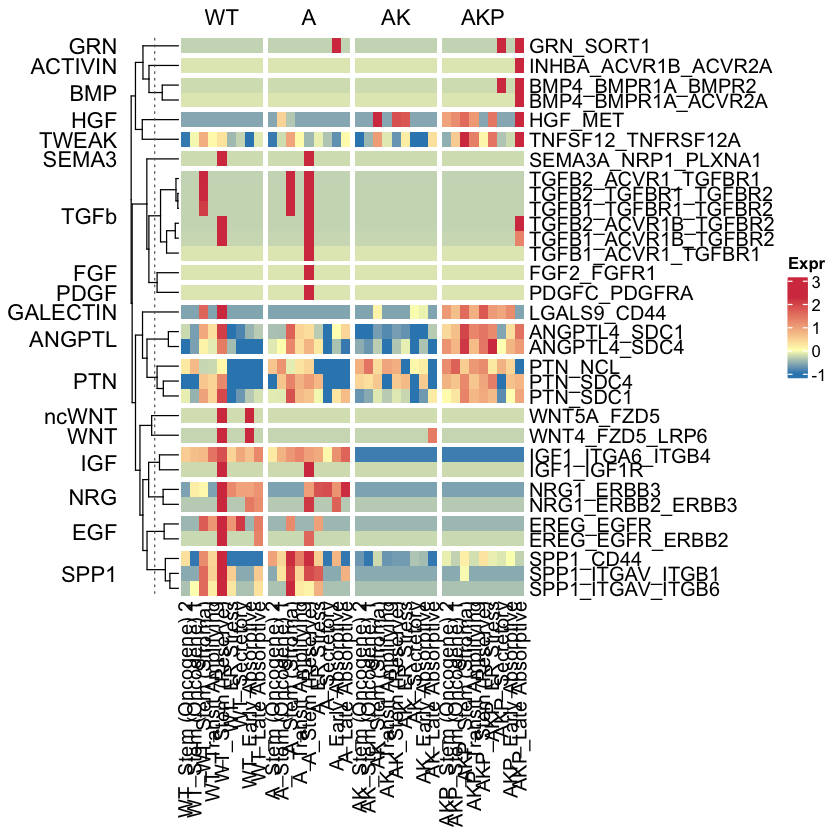

In [8]:
#Generate interaction-level Heatmap:

dmat_scaledint <- dCC_interaction %>% 
                ungroup %>% #No need to filter for fibro source as in path V
                select(interaction_name, prob, Columns) %>%
                pivot_wider(names_from = Columns, values_from = prob)


dmat_scaledint <- data.table::transpose(dmat_scaledint, 
                                        keep.names = "names") %>% 
  column_to_rownames(var="names")

names(dmat_scaledint) <- dmat_scaledint %>% slice(1) %>% unlist()
dmat_scaledint <- dmat_scaledint %>% slice(-1)

dmat_scaledint[is.na(dmat_scaledint)] = 0 #While it would be great to not turn NA into 0 (as we don't really need hclust) having intreactions with only one entry and thus zero variance isn't ideal when scaling -> introduces NaN

dmat_scaledint <- dmat_scaledint %>% 
                  mutate(across(everything(), as.double)) %>% 
                  rownames_to_column(var = "interaction_name") %>% 
                  mutate(across(where(is.numeric), scale, center=TRUE))


dmat_scaledint <- data.table::transpose(dmat_scaledint, 
                                        keep.names = "names") %>% 
  column_to_rownames(var="names")
names(dmat_scaledint) <- dmat_scaledint %>% slice(1) %>% unlist()
dmat_scaledint <- dmat_scaledint %>% slice(-1) 
dmat_scaledint <- dmat_scaledint %>% 
                  mutate(across(everything(), as.numeric)) %>%
                  rownames_to_column(var="names") %>% 
                  arrange(names) %>% 
                  column_to_rownames(var="names")



dCCanno_ecm <- CellChatDB.mouse$interaction %>% 
                      select(pathway_name, annotation) %>% 
                      distinct() %>% 
                      filter(annotation == "ECM-Receptor")
dCCanno_cellcont <- CellChatDB.mouse$interaction %>% 
                      select(pathway_name, annotation) %>% 
                      distinct() %>% 
                      filter(annotation == "Cell-Cell Contact")
dCCanno_secreted <- CellChatDB.mouse$interaction %>% 
                      select(pathway_name, annotation) %>% 
                      distinct() %>% 
                      filter(annotation == "Secreted Signaling")
htmp_rowplsit_ECMvsGF <- dCC_interaction %>% 
                        ungroup %>% 
                        select(pathway_name, interaction_name) %>% 
                        distinct() %>% 
                        mutate(Type = case_when(
                          pathway_name %in% dCCanno_ecm$pathway_name ~ "ECM",
                          pathway_name %in% dCCanno_cellcont$pathway_name ~ "CellContact",
                          pathway_name %in% dCCanno_secreted$pathway_name ~ "Secreted"
                        ))
htmp_colsplit_geno <- dCC_interaction %>% 
                        ungroup %>% 
                        select(Genotype, Columns) %>% 
                        distinct() %>% 
                        column_to_rownames(var = "Columns")

htmp_rowplsit_path <- dCC_interaction %>% 
                        ungroup %>% 
                        select(pathway_name, interaction_name) %>% 
                        distinct() %>% 
                        column_to_rownames(var = "interaction_name")


Heatmap(
        as.matrix(
          dmat_scaledint %>% rownames_to_column("interaction_name") %>% 
            filter(interaction_name %in% 
                    filter(htmp_rowplsit_ECMvsGF, 
                            Type=="Secreted")$interaction_name) %>% 
            column_to_rownames("interaction_name")
        ), 
        name = "Expr",
        
        column_split = htmp_colsplit_geno,
        cluster_columns = FALSE,
        cluster_column_slices = FALSE,
        column_order = levels(droplevels(dCC_interaction$Columns)),
        
        row_split = htmp_rowplsit_path %>%
                    rownames_to_column("interaction_name") %>%
                    filter(interaction_name %in% 
                    filter(htmp_rowplsit_ECMvsGF, 
                            Type=="Secreted")$interaction_name) %>%
                    arrange(interaction_name) %>% 
                    column_to_rownames("interaction_name"),
        cluster_rows = TRUE,
        cluster_row_slices = TRUE,
        
        row_title_rot = 0,
        
        
        col=circlize::colorRamp2(
                    c(
                      round(quantile(
                        dmat_scaledint %>% 
                          rownames_to_column("interaction_name") %>% 
                          filter(interaction_name %in% 
                    filter(htmp_rowplsit_ECMvsGF, 
                            Type=="Secreted")$interaction_name) %>%
                          column_to_rownames("interaction_name")
                        , 
                        c(0.04,0.96), na.rm = TRUE)[1], digits = 1),
                      0, 
                      round(quantile(
                        dmat_scaledint %>% 
                          rownames_to_column("interaction_name") %>% 
                          filter(interaction_name %in% 
                    filter(htmp_rowplsit_ECMvsGF, 
                            Type=="Secreted")$interaction_name) %>%
                          column_to_rownames("interaction_name")
                        , 
                        c(0.04,0.96), na.rm = TRUE)[2], digits = 1)), 
                    c("#3288BD", "#FEFEBD", "#D53E4F")),
        na_col = "#666666"
        
        )

,ANGPTL,COLLAGEN,FN1,IGF,JAM,LAMININ,ncWNT,NECTIN,NRG,PTN,⋯,NOTCH,SEMA3,TGFb,GRN,HGF,FGF,PDGF,AGRN,ACTIVIN,BMP
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WT_Early Absorptive,0.017353949244236,0.357772046874184,0.0579770267631809,0.000433226839931349,0.00467975418435276,0.0289008808895214,0.000228332674525844,0.00174324384681371,0.00046936065588172,0.0838604210054485,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
WT_ER Stress,0.0161036920590816,0.276727330937346,0.0244132106925143,0.00037699478298737,0.0111812230748605,0.0356608147412922,NA,0.00332473602262546,0.000270617185128424,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
WT_Late Absorptive,0.0169855943170667,0.423319045259955,0.0943831098637904,0.00059995373759703,0.00937655495474527,0.0429047831290563,NA,0.00171413093621111,0.000462021557784184,0.0892353853420495,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
WT_Secretory,0.0149028076832146,0.393465841292018,0.0581531338797406,0.000506738062336673,0.00744152610614481,0.0427008175627446,NA,NA,0.000231249872900648,0.0717877075245682,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
WT_Stem (Oncogene) 1,0.0179304179231952,0.296570827364975,0.0610385199954887,0.000437477589962057,0.00540396447467926,0.0382098098918742,NA,NA,0.000115940175938351,0.23782837885102,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
WT_Stem (Oncogene) 2,0.0184489988021315,0.499279670887477,0.0863669555380773,0.000398423623613645,0.00479655241454803,0.0398910421020851,NA,0.00147803935814537,NA,0.214017283947039,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
WT_Stem (Reserve),0.0376294824225275,1.76328421450424,0.415159300214648,0.000881834753590161,0.0182861987261091,0.13322815366193,0.000454535370842657,0.00478129417313099,0.00110453754518958,0.38329779704223,⋯,0.00889036680850481,0.000153706140274417,0.00143562305649741,NA,NA,NA,NA,NA,NA,NA
WT_Stem (Stroma),0.0279557853538042,1.11106925811381,0.237307034600231,0.000455870936589871,0.0113975144183411,0.0747931670414164,NA,0.00199011227732041,0.000105087907334095,0.292238775953994,⋯,NA,NA,0.00181703120725588,NA,NA,NA,NA,NA,NA,NA
WT_Transit Amplifying,0.0243230113403369,0.904112987707967,0.1733458396623,0.000663186174200323,0.00788775065046451,0.0643512358881922,NA,0.00156773798265618,NA,0.269198240286587,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


pathway_name,ANGPTL,COLLAGEN,FN1,IGF,JAM,LAMININ,ncWNT,NECTIN,NRG,⋯,NOTCH,SEMA3,TGFb,GRN,HGF,FGF,PDGF,AGRN,ACTIVIN,BMP
<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
WT_Early Absorptive,-0.75913994,-0.88124362,-0.82576486,0.60437513,-0.712746720,-0.64735202,2.4983795,0.277243325,1.32792148,⋯,-0.46396469,-0.235336,-0.2837087,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_ER Stress,-0.92092237,-1.11372824,-1.21615606,0.40669630,1.174335399,-0.38278693,-0.2263552,1.410839216,0.52829085,⋯,-0.46396469,-0.235336,-0.2837087,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_Late Absorptive,-0.80680481,-0.69321571,-0.40231437,1.19048881,0.650521935,-0.09927807,-0.2263552,0.256375516,1.29839313,⋯,-0.46396469,-0.235336,-0.2837087,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_Secretory,-1.07631600,-0.77885251,-0.82371651,0.86279733,0.088870653,-0.10726071,-0.2263552,-0.972294354,0.36989919,⋯,-0.46396469,-0.235336,-0.2837087,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_Stem (Oncogene) 1,-0.68454528,-1.05680524,-0.79015568,0.61931826,-0.502541255,-0.28302632,-0.2263552,-0.972294354,-0.09404141,⋯,-0.46396469,-0.235336,-0.2837087,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_Stem (Oncogene) 2,-0.61744126,-0.47531530,-0.49555276,0.48202749,-0.678845481,-0.21722754,-0.2263552,0.087147715,-0.56051870,⋯,-0.46396469,-0.235336,-0.2837087,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_Stem (Reserve),1.86450037,3.15060414,3.32873340,2.18141662,3.236588213,3.43572852,5.1976969,2.454883796,3.88351182,⋯,2.99773340,3.257216,0.6630758,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_Stem (Stroma),0.61273050,1.27966238,1.26007831,0.68397845,1.237114985,1.14874497,-0.2263552,0.454195853,-0.13770476,⋯,-0.46396469,-0.235336,0.9146121,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025
WT_Transit Amplifying,0.14265199,0.68598828,0.51612573,1.41277685,0.218389439,0.74007670,-0.2263552,0.151442685,-0.56051870,⋯,-0.46396469,-0.235336,-0.2837087,-0.2943466,-0.5894122,-0.1666667,-0.1666667,-0.7077394,-0.1666667,-0.2369025


,WT_Early Absorptive,WT_ER Stress,WT_Late Absorptive,WT_Secretory,WT_Stem (Oncogene) 1,WT_Stem (Oncogene) 2,WT_Stem (Reserve),WT_Stem (Stroma),WT_Transit Amplifying,A_Early Absorptive,⋯,AK_Transit Amplifying,AKP_Early Absorptive,AKP_ER Stress,AKP_Late Absorptive,AKP_Secretory,AKP_Stem (Oncogene) 1,AKP_Stem (Oncogene) 2,AKP_Stem (Reserve),AKP_Stem (Stroma),AKP_Transit Amplifying
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACTIVIN,-0.166666667,-0.16666667,-0.16666667,-0.16666667,-0.16666667,-0.16666667,-0.1666667,-0.1666667,-0.16666667,-0.16666667,⋯,-0.16666667,-0.16666667,-0.1666667,5.83333333,-0.16666667,-0.16666667,-0.16666667,-0.1666667,-0.16666667,-0.166666667
AGRN,-0.707739400,-0.70773940,-0.70773940,-0.70773940,-0.70773940,-0.70773940,-0.7077394,-0.7077394,-0.70773940,-0.70773940,⋯,1.09502742,1.70684613,-0.7077394,-0.70773940,1.94841759,1.02190909,1.39673571,2.6390264,-0.70773940,0.939083052
ANGPTL,-0.759139936,-0.92092237,-0.80680481,-1.07631600,-0.68454528,-0.61744126,1.8645004,0.6127305,0.14265199,-0.18072319,⋯,-1.01189141,0.55636655,1.8199068,1.37671711,-0.36753075,0.73016778,0.74134843,1.5185021,2.16256808,1.081572707
BMP,-0.236902528,-0.23690253,-0.23690253,-0.23690253,-0.23690253,-0.23690253,-0.2369025,-0.2369025,-0.23690253,-0.23690253,⋯,-0.23690253,-0.23690253,-0.2369025,4.59867546,3.45601050,-0.23690253,-0.23690253,-0.2369025,-0.23690253,-0.236902528
COLLAGEN,-0.881243619,-1.11372824,-0.69321571,-0.77885251,-1.05680524,-0.47531530,3.1506041,1.2796624,0.68598828,-0.30831892,⋯,-1.14320556,-0.05427957,0.6496945,0.25752242,-0.42214205,0.08934201,-0.01224489,0.7157198,1.24774359,0.304748297
EGF,-0.399549504,0.43772261,1.48552372,0.98688407,-0.39954950,-0.39954950,5.0612386,0.7853674,0.43693105,-0.39954950,⋯,-0.39954950,-0.39954950,-0.3995495,-0.39954950,-0.39954950,-0.39954950,-0.39954950,-0.3995495,-0.39954950,-0.399549504
EPHA,-0.282787086,-0.28278709,1.10677193,-0.28278709,0.54996882,-0.28278709,5.4404492,0.8033993,0.86581045,-0.28278709,⋯,-0.28278709,-0.28278709,-0.2827871,-0.28278709,-0.28278709,-0.28278709,-0.28278709,-0.2827871,-0.28278709,-0.282787086
FGF,-0.166666667,-0.16666667,-0.16666667,-0.16666667,-0.16666667,-0.16666667,-0.1666667,-0.1666667,-0.16666667,-0.16666667,⋯,-0.16666667,-0.16666667,-0.1666667,-0.16666667,-0.16666667,-0.16666667,-0.16666667,-0.1666667,-0.16666667,-0.166666667
FN1,-0.825764863,-1.21615606,-0.40231437,-0.82371651,-0.79015568,-0.49555276,3.3287334,1.2600783,0.51612573,-0.39886347,⋯,-0.98375585,0.03815852,0.6154740,0.25400346,-0.63130848,0.15759655,0.07211541,0.6719003,1.22567580,0.333731740


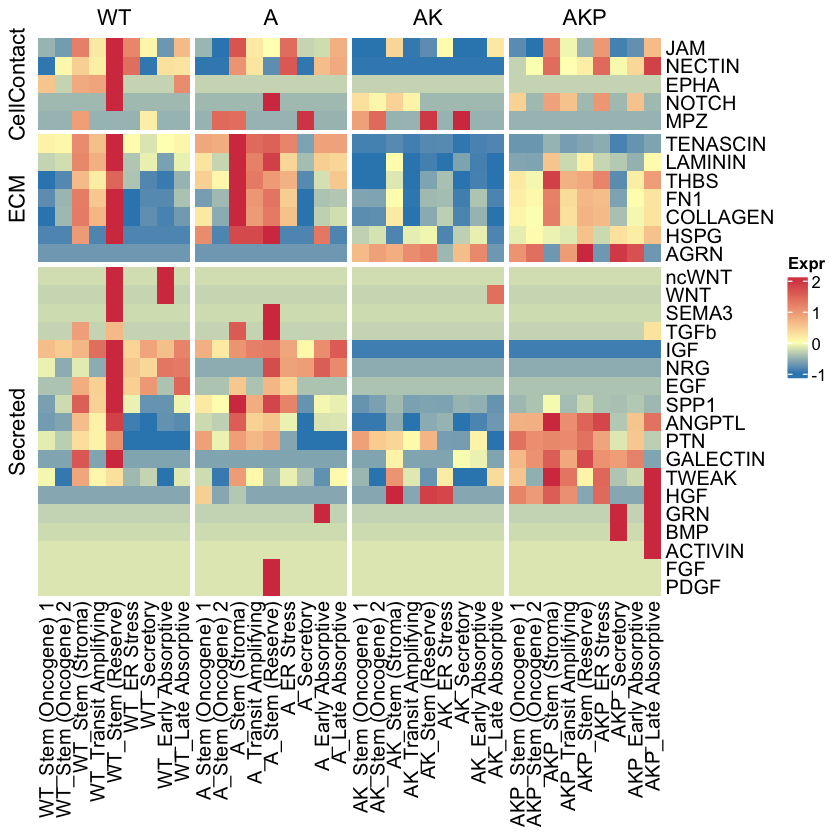

In [9]:
#Generate pathway-level heatmap

dmat_scaledpath <- dCC_pathway %>%
                    filter(Cluster !="fibroblast") %>%
                    ungroup %>% 
                    select(pathway_name, prob, Columns) %>%
                    pivot_wider(names_from = Columns, values_from = prob)

dmat_scaledpath <- data.table::transpose(dmat_scaledpath, keep.names = "names") %>% column_to_rownames(var="names")

names(dmat_scaledpath) <- dmat_scaledpath %>% slice(1) %>% unlist()
dmat_scaledpath <- dmat_scaledpath %>% slice(-1)
dmat_scaledpath
dmat_scaledpath[is.na(dmat_scaledpath)] = 0
dmat_scaledpath <- dmat_scaledpath %>% 
                    mutate(across(everything(), as.double)) %>% 
                    rownames_to_column(var = "pathway_name") %>% 
                    mutate(across(where(is.numeric), scale))
dmat_scaledpath

dmat_scaledpath <- data.table::transpose(dmat_scaledpath, keep.names = "names") %>% column_to_rownames(var="names")
names(dmat_scaledpath) <- dmat_scaledpath %>% slice(1) %>% unlist()
dmat_scaledpath <- dmat_scaledpath %>% slice(-1) 
dmat_scaledpath <- dmat_scaledpath %>% 
                    mutate(across(everything(), as.numeric)) %>% 
                    rownames_to_column(var="names") %>% 
                    arrange(names) %>% 
                    column_to_rownames(var="names")
dmat_scaledpath

Heatmap(
        as.matrix(dmat_scaledpath), 
        name = "Expr",
        
        column_split = htmp_colsplit_geno,
        cluster_columns = FALSE,
        cluster_column_slices = FALSE,
        column_order = levels(droplevels(filter(dCC_pathway, Cluster!="fibroblast")$Columns)),
        
        row_split = htmp_rowplsit_ECMvsGF %>% 
                    select(!interaction_name) %>% 
                    distinct() %>% 
                    filter(pathway_name %in% rownames(dmat_scaledpath)) %>%
                    arrange(pathway_name) %>%
                    column_to_rownames(var="pathway_name"),
        cluster_rows = FALSE,
        cluster_row_slices = FALSE,
        row_order = c(
          "JAM","NECTIN","EPHA","NOTCH","MPZ",
          "TENASCIN","LAMININ","THBS","FN1","COLLAGEN","HSPG","AGRN",
          "ncWNT","WNT","SEMA3","TGFb","IGF","NRG","EGF","SPP1","ANGPTL","PTN","GALECTIN","TWEAK","HGF","GRN","BMP",
          "ACTIVIN","FGF","PDGF"),
        
        col=circlize::colorRamp2(
                    c(
                      round(quantile(dmat_scaledpath, c(0.04,0.96), na.rm = TRUE)[1], digits = 1), 
                      0, 
                      round(quantile(dmat_scaledpath, c(0.04,0.96), na.rm = TRUE)[2], digits = 1)), 
                    c("#3288BD", "#FEFEBD", "#D53E4F")),
        na_col = "blue3"
        
        )

# Expression of Ligand and Receptor genes



As described in the manuscript, we focused into looking at the ligand expression by the fibroblast cells and the receptor expression by the epithelial cells



#Load cell-communication results dataframe

    interactionDF  <- interactionDF %>% filter(annotation=="Secreted Signaling") %>%  
                        ungroup() %>% select(ligand, receptor, pathway_name)
    ligandDF <- interactionDF %>% select(!receptor) %>% distinct()
    receptorDF <- interactionDF %>% select(!ligand) %>% distinct()
    #We will get rid of the FGF, PDGF and ACTIVIN pathways
    gLigands <- ligandDF %>% filter(!pathway_name%in%c("FGF", "PDGF", "ACTIVIN"))
    gLigands <- gLigands$ligand
    gLigands
    gReceptors <- c("TGFbR1", "TGFbR2", "ACVR1B", "TGFbR2", "ACVR1", 
                    "FZD5","LRP6", "Fzd5", "Egfr","EGFR","ERBB2", "Erbb3", "ERBB2", 
                    "ERBB3", "Igf1r", "ITGA6", "ITGB4", "Tnfrsf12a", "Cd44", 
                    "ITGAV", "ITGB1", "ITGAV", "ITGB6", "Sdc1", "Sdc4", "Sdc1", 
                    "Sdc4", "Ncl","NRP1", "PLXNA1", "Cd44", "Met", "Sort1", 
                    "BMPR1A", "ACVR2A", "BMPR1A","BMPR2")
    gReceptors <- as.character(unique(lapply(X=gReceptors, FUN = str_to_sentence)))
    gReceptors

In [10]:
#Custom order to gene lists

    gLigands <- c(
                "Wnt5a","Wnt4","Sema3a","Tgfb2","Tgfb1","Igf1","Nrg1","Ereg",
                "Spp1","Angptl4","Ptn","Lgals9","Tnfsf12","Hgf","Grn","Bmp4"         
                )
    gReceptors <- c(
                    "Fzd5","Lrp6","Nrp1","Plxna1","Acvr1","Tgfbr1","Tgfbr2",
                    "Acvr1b","Itga6","Itgb4","Igf1r","Erbb2","Erbb3","Egfr","Cd44",
                    "Itgav","Itgb1","Itgb6","Sdc1","Sdc4","Ncl","Tnfrsf12a","Met",
                    "Sort1","Bmpr1a","Bmpr2","Acvr2a"
                    )

Dotplots

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



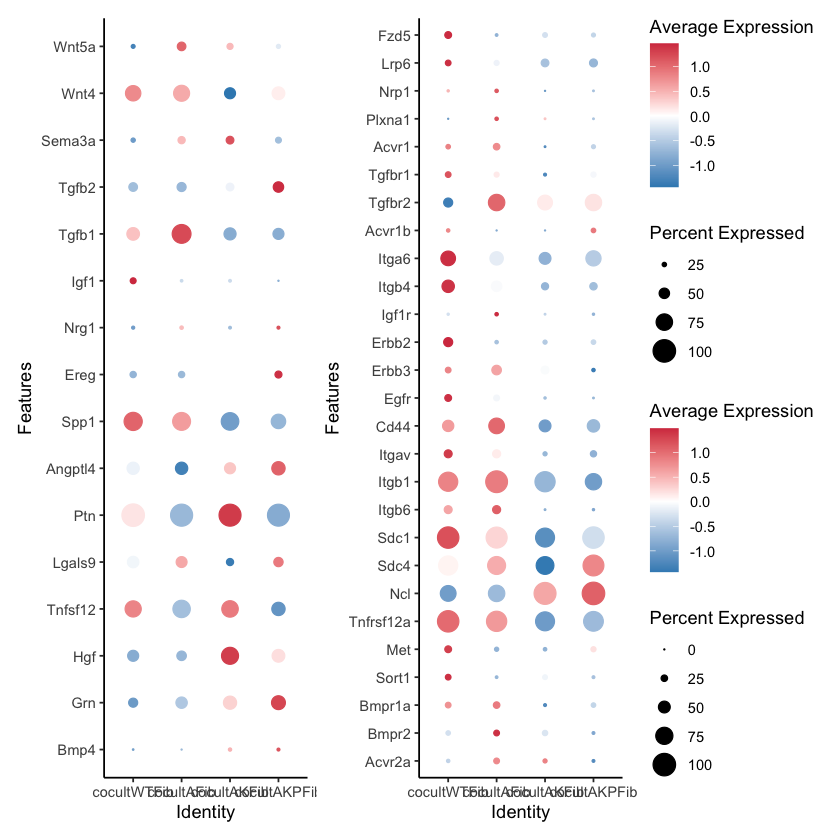

In [11]:
#Make plots for Fig S5A

    pDotP_FIBligands <- DotPlot(
                            subset(downsampled_cocultsINT, subset = finalPOPS == "fibroblast"
                                    ),
                            assay = "RNA",
                            features = rev(gLigands),
                            group.by = "orig.ident"
                        ) + 
                        scale_colour_gradient2(low = "#3288BD", mid = "white", 
                        high = "#D53E4F"
                        ) + 
                        coord_flip() +
                        theme_classic()
    pDotP_EPIreceptors <- DotPlot(
                                subset(downsampled_cocultsINT, subset = finalPOPS != "fibroblast"
                                        ),
                                assay = "RNA",
                                features = rev(gReceptors),
                                group.by = "orig.ident"
                            ) + 
                            scale_colour_gradient2(low = "#3288BD", 
                                mid = "white", high = "#D53E4F"
                            ) + 
                            coord_flip() +
                            theme_classic()

    pDotP_FIBligands + pDotP_EPIreceptors + 
    plot_layout(ncol = 2, nrow = 1, guides = "collect")


Quantify changes in UCell scores

#Compute separately for epithelia and fibroblasts and add as metadata
    
    downsampled_cocultsINT_fib <- UCell::AddModuleScore_UCell(
                obj = subset(downsampled_cocultsINT, subset = finalPOPS == "fibroblast"
                        ),
                features = list(Ligands = gLigands),
                assay = "RNA",
                storeRanks = FALSE,
                ncores = 12
    )
    downsampled_cocultsINT_epi <- UCell::AddModuleScore_UCell(
                obj = subset(downsampled_cocultsINT, subset = finalPOPS != "fibroblast"
                        ),
                features = list(Receptors = gReceptors),
                assay = "RNA",
                storeRanks = FALSE,
                ncores = 12
    )
    downsampled_cocultsINT <- AddMetaData(downsampled_cocultsINT, metadata = select(downsampled_cocultsINT_fib@meta.data, Ligands_UCell))
    downsampled_cocultsINT <- AddMetaData(downsampled_cocultsINT, metadata = select(downsampled_cocultsINT_epi@meta.data, Receptors_UCell))

In [12]:
#Create UCell score dataframe

    dLRscores <- downsampled_cocultsINT@meta.data %>% 
                select(orig.ident, finalPOPS) %>% 
                mutate(type = case_when(finalPOPS == "fibroblast" ~ "fibroblast",
                                        TRUE ~ "epithelia"))
    dLRscores <- left_join(
                    x=dLRscores %>% rownames_to_column(var="Cell"),
                    y=as.data.frame(select(.data=dsub_FigS5_INT@meta.data, Ligands_UCell, Receptors_UCell)) %>% rownames_to_column(var="Cell"),
                    by = "Cell"
                    ) %>%
                unite(Ligands_UCell, Receptors_UCell, col = "scores", sep = "", na.rm = TRUE) %>%
                select(!finalPOPS) %>%
                column_to_rownames(var = "Cell")
    dLRscores$scores <- as.numeric(dLRscores$scores)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': object 'dsub_FigS5_INT' not found


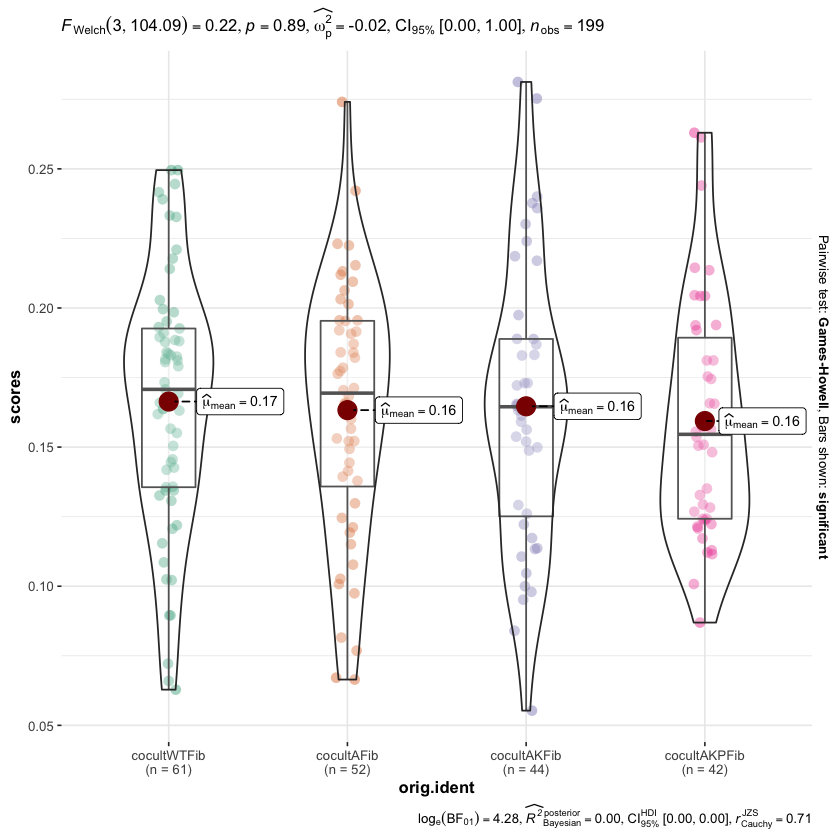

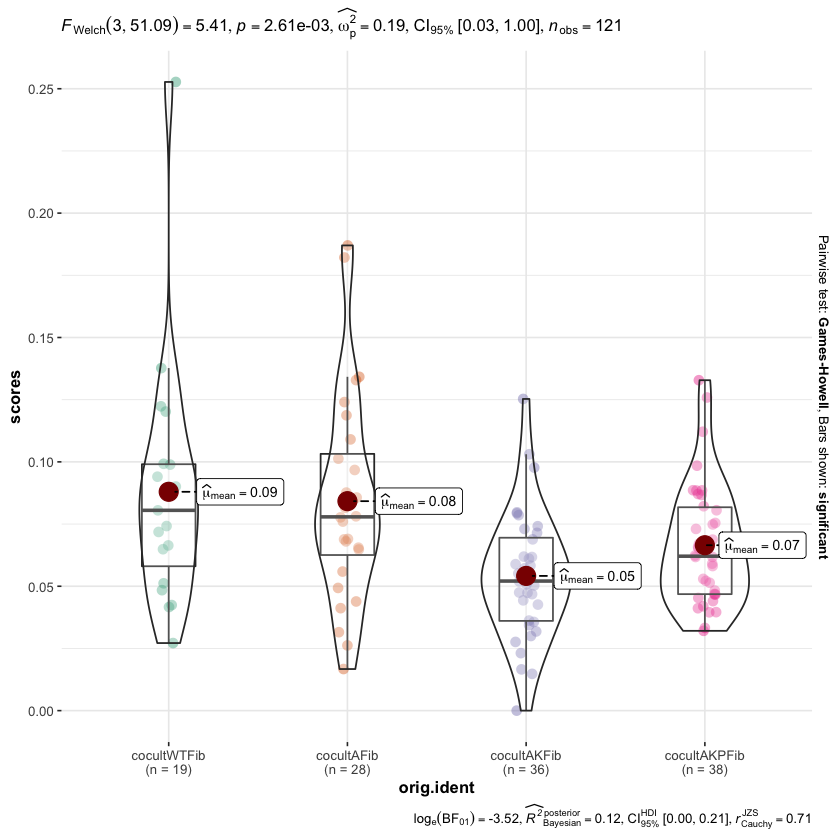

In [ ]:
#Plot using ggstats

    ggstatsplot::ggbetweenstats(data = filter(.data=dLRscores, type=="fibroblast"), 
    x=orig.ident, 
    y=scores,
    )
    ggstatsplot::ggbetweenstats(data = filter(.data=dLRscores, type=="epithelia"), 
    x=orig.ident, 
    y=scores,
    )

# Figure S4G, receptor expression across epithelial clusters

In [ ]:
INTepi <- readRDS("data/INTepi.rds") # INTepi.rds deposited at Zenodo: https://zenodo.org/record/7586958
INTepi_subset <- subset(INTepi, subset = orig.ident %in% c("monoWT"))

## WNT

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"Removed 265 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 265 rows containing missing values (`geom_point()`)."
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"Removed 297 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 297 rows containing missing values (`geom_point()`)."


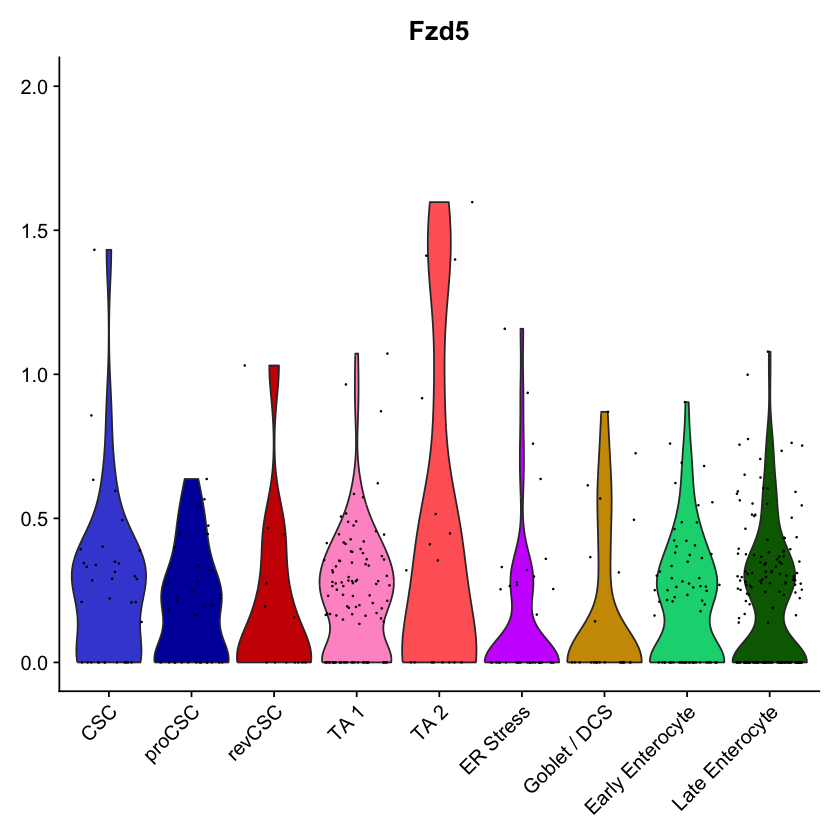

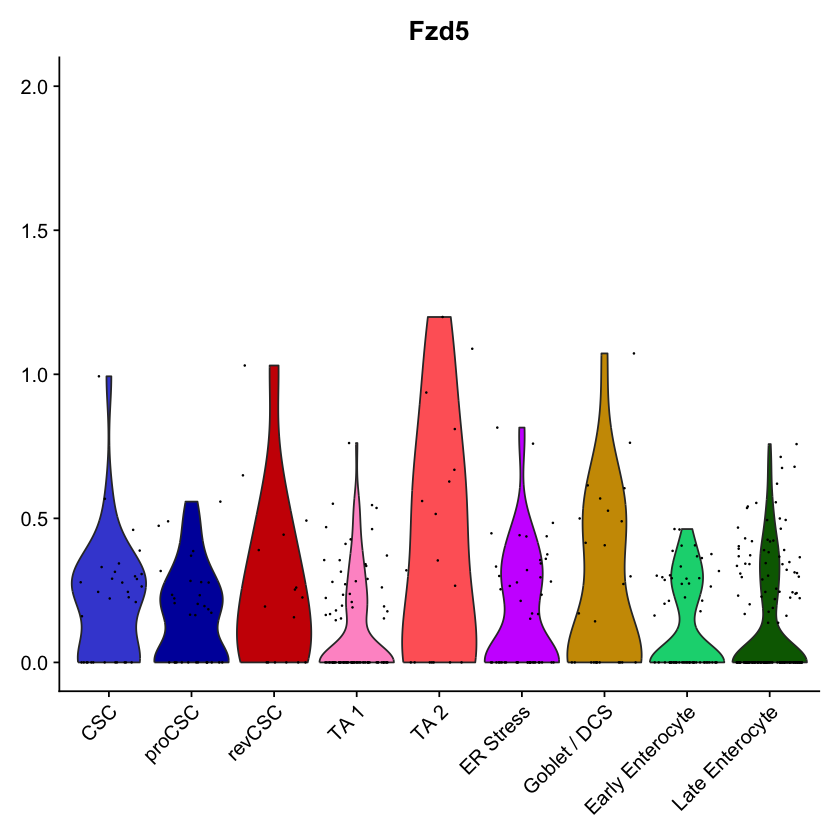

In [ ]:
INTepi_subset@active.ident <- INTepi_subset$curatedCLUST

VlnPlot(INTepi_subset, features = "Fzd5", cols = c(
    "#434ED5", "#021EAA", "#CC0102", "#FF99CC",
    "#FF6666", "#CC01FF", "#CC9900", "#00D47F", "#036601"
)) + scale_y_continuous(limits = c(0, 2)) +
    labs(title = "Fzd5", x = NULL, y = NULL, colour = "Clusters") +
    theme(legend.position = "none")

VlnPlot(INTepi_subset, features = "Lrp6", cols = c(
    "#434ED5", "#021EAA", "#CC0102", "#FF99CC",
    "#FF6666", "#CC01FF", "#CC9900", "#00D47F", "#036601"
)) + scale_y_continuous(limits = c(0, 2)) +
    labs(title = "Lrp6", x = NULL, y = NULL, colour = "Clusters") +
    theme(legend.position = "none")

## ERBB

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"Removed 320 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 320 rows containing missing values (`geom_point()`)."
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"Removed 226 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 226 rows containing missing values (`geom_point()`)."


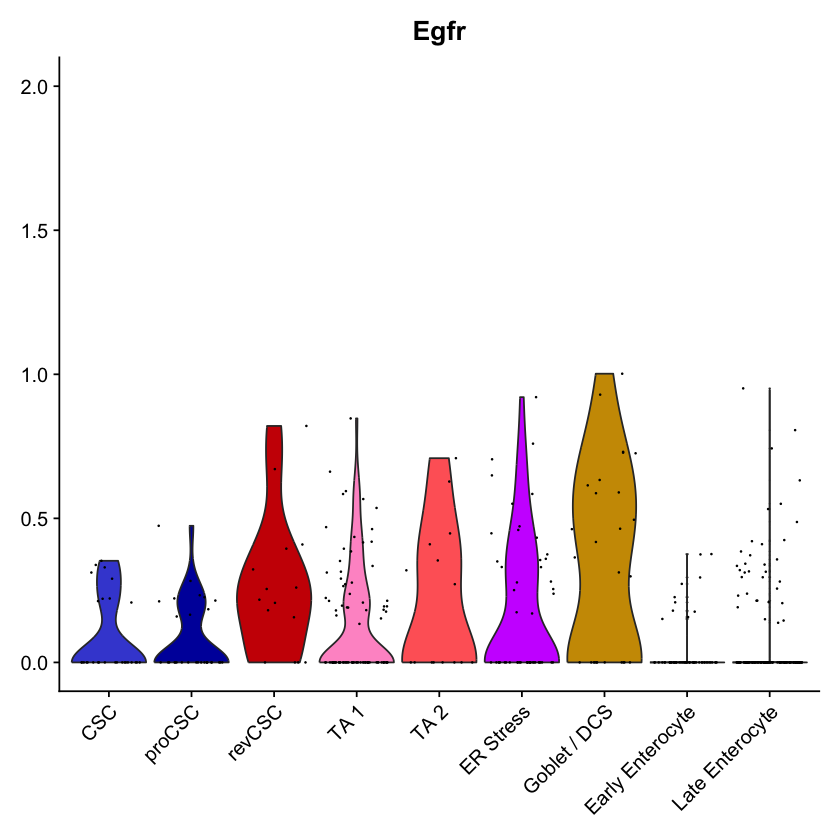

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"Removed 167 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 167 rows containing missing values (`geom_point()`)."


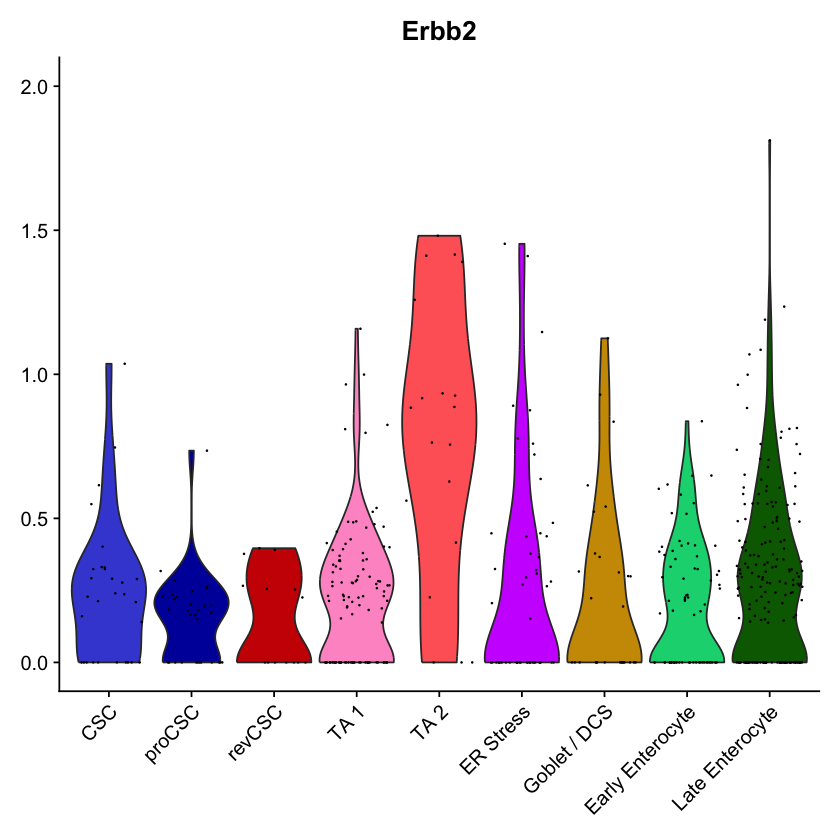

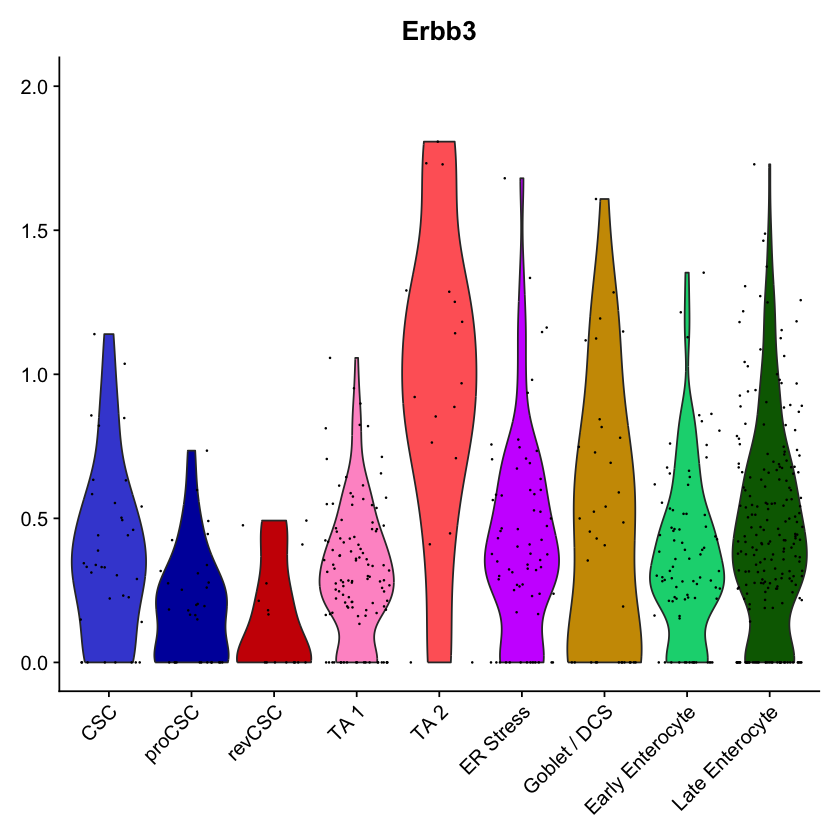

In [ ]:
VlnPlot(INTepi_subset, features = "Egfr", cols = c(
    "#434ED5", "#021EAA", "#CC0102", "#FF99CC",
    "#FF6666", "#CC01FF", "#CC9900", "#00D47F", "#036601"
)) + scale_y_continuous(limits = c(0, 2)) +
    labs(title = "Egfr", x = NULL, y = NULL, colour = "Clusters") +
    theme(legend.position = "none")

VlnPlot(INTepi_subset, features = "Erbb2", cols = c(
    "#434ED5", "#021EAA", "#CC0102", "#FF99CC",
    "#FF6666", "#CC01FF", "#CC9900", "#00D47F", "#036601"
)) + scale_y_continuous(limits = c(0, 2)) +
    labs(title = "Erbb2", x = NULL, y = NULL, colour = "Clusters") +
    theme(legend.position = "none")

    VlnPlot(INTepi_subset, features = "Erbb3", cols = c(
    "#434ED5", "#021EAA", "#CC0102", "#FF99CC",
    "#FF6666", "#CC01FF", "#CC9900", "#00D47F", "#036601"
)) + scale_y_continuous(limits = c(0, 2)) +
    labs(title = "Erbb3", x = NULL, y = NULL, colour = "Clusters") +
    theme(legend.position = "none")